In [14]:
import torch
from torch import nn
from matplotlib import pyplot as plt

In [22]:
tri_coef = nn.Parameter(torch.rand((2, )))
tri_bias = nn.Parameter(torch.rand((1, )))
x = torch.FloatTensor(range(24)).view(-1, 1) * torch.pi / 12
x = torch.cat([torch.cos(x), torch.sin(x)], dim=1)
output = torch.relu(x.mul(tri_coef).sum(dim=1)+tri_bias)
output = output.detach().numpy()

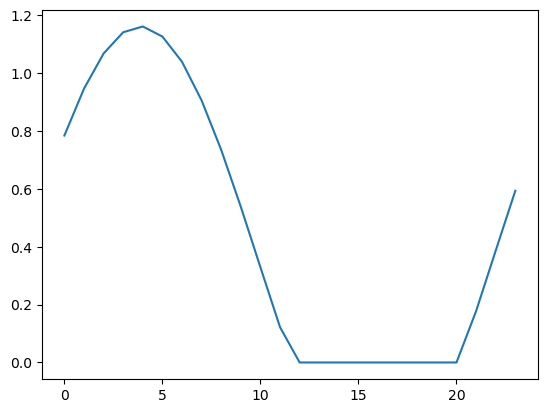

In [23]:
plt.plot(range(24), output)

In [ ]:
import numpy as np
import pandas as pd
from pandas import Timedelta
from tools.get_prediction_data import *
today = pd.Timestamp.now()
day_delta = lambda x: Timedelta(days=x)

import torch
from torch import nn
from tools.DARNN import *
device = torch.device('cuda')

In [ ]:
class QARNN(nn.Module):
    def __init__(self, T, P, n, m, p):
        super().__init__()
        # T: Time step
        # m: dimension of Encoder hidden state
        # p: dimension of Deocder hidden state

        self.T = T
        self.P = P
        self.m = m
        self.p = p
        self.encoder1 = Encoder(T+P, n-5, m)
        self.encoder2 = Encoder(T+P, 5, m)
        self.decoder1 = Decoder(m, p)
        self.decoder2 = Decoder(m, p)
        self.linear1 = nn.Linear(2*(m+p), 2*p)
        self.linear2 = nn.Linear(2*p, P)
        self.relu = nn.ReLU()

    def forward(self, enc_data, dec_data):
        # enc: (-1 x T+P x n)
        # dec: (-1 x T x 1)
        batch_size = dec_data.shape[0]
        h0 = torch.zeros(1, batch_size, self.m, device=dec_data.device)
        d0 = torch.zeros(1, batch_size, self.p, device=dec_data.device)

        H1 = self.encoder1(enc_data[:, :, :-5], h0, h0, self.T+self.P)  # (-1 x T+P x m)
        H2 = self.encoder2(enc_data[:, :, -5:], h0, h0, self.T+self.P)  # (-1 x T+P x m)

        dec_output1 = self.decoder1(H1, dec_data, d0, d0, self.T)  # (-1 x 1 x m+p)
        dec_output2 = self.decoder2(H2, dec_data, d0, d0, self.T)
        dec_output1 = dec_output1.squeeze(dim=1)  # (-1 x m+p)
        dec_output2 = dec_output2.squeeze(dim=1)  # (-1 x m+p)

        output = torch.cat([dec_output1, dec_output2], dim=1)  # (-1 x 2(m+p))
        output = self.relu(self.linear1(output))  # (-1 x 2p)
        output = self.relu(self.linear2(output))  # (-1 x P)

        return output
    

    def get_input_attention_score(self):
        if type(self.encoder2.alpha_t) == list:
            self.encoder2.alpha_t = torch.cat(self.encoder2.alpha_t, dim=1)  # (-1 x T+P x m)
        return self.encoder2.alpha_t

In [ ]:
x1 = torch.rand((16, 120, 18))
x2 = torch.rand((16, 72, 1))
model = QARNN(72, 48, 18, 32, 32)
output = model(x1, x2)
output.shape, output.max()

In [ ]:
model.get_input_attention_score()